In [1]:
import pandas as pd
import numpy as np
from kan import *
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

In [2]:
plt.rcParams.update({
    'font.size': 12,               # Font size
    'axes.labelsize': 15,          # Label size
    'axes.titlesize': 15,          # Title size
    'axes.linewidth': 1.2,         # Axis line width
    'xtick.labelsize': 10,         # Size of x-axis tick labels
    'ytick.labelsize': 10,         # Size of y-axis tick labels
    'xtick.major.size': 6,         # Length of major ticks on the x-axis
    'ytick.major.size': 6,         # Length of major ticks on the y-axis
    'xtick.major.width': 1.0,      # Width of major ticks on the x-axis
    'ytick.major.width': 1.0,      # Width of major ticks on the y-axis
    'figure.dpi': 300,             # Image resolution
    'savefig.dpi': 300,            # Resolution for saving figures
    'figure.figsize': (12, 5),     # Figure size
})

## Application

In [3]:
earthquakes = pd.read_csv('earthquakes.csv')
earthquakes = earthquakes.iloc[1:]
earthquakes = earthquakes[['Tsu', 'Latitude', 'Longitude', 'Mag', 'Focal Depth (km)']]
earthquakes['Tsu'] = earthquakes['Tsu'].notna().astype(int)
earthquakes.dropna(inplace=True)

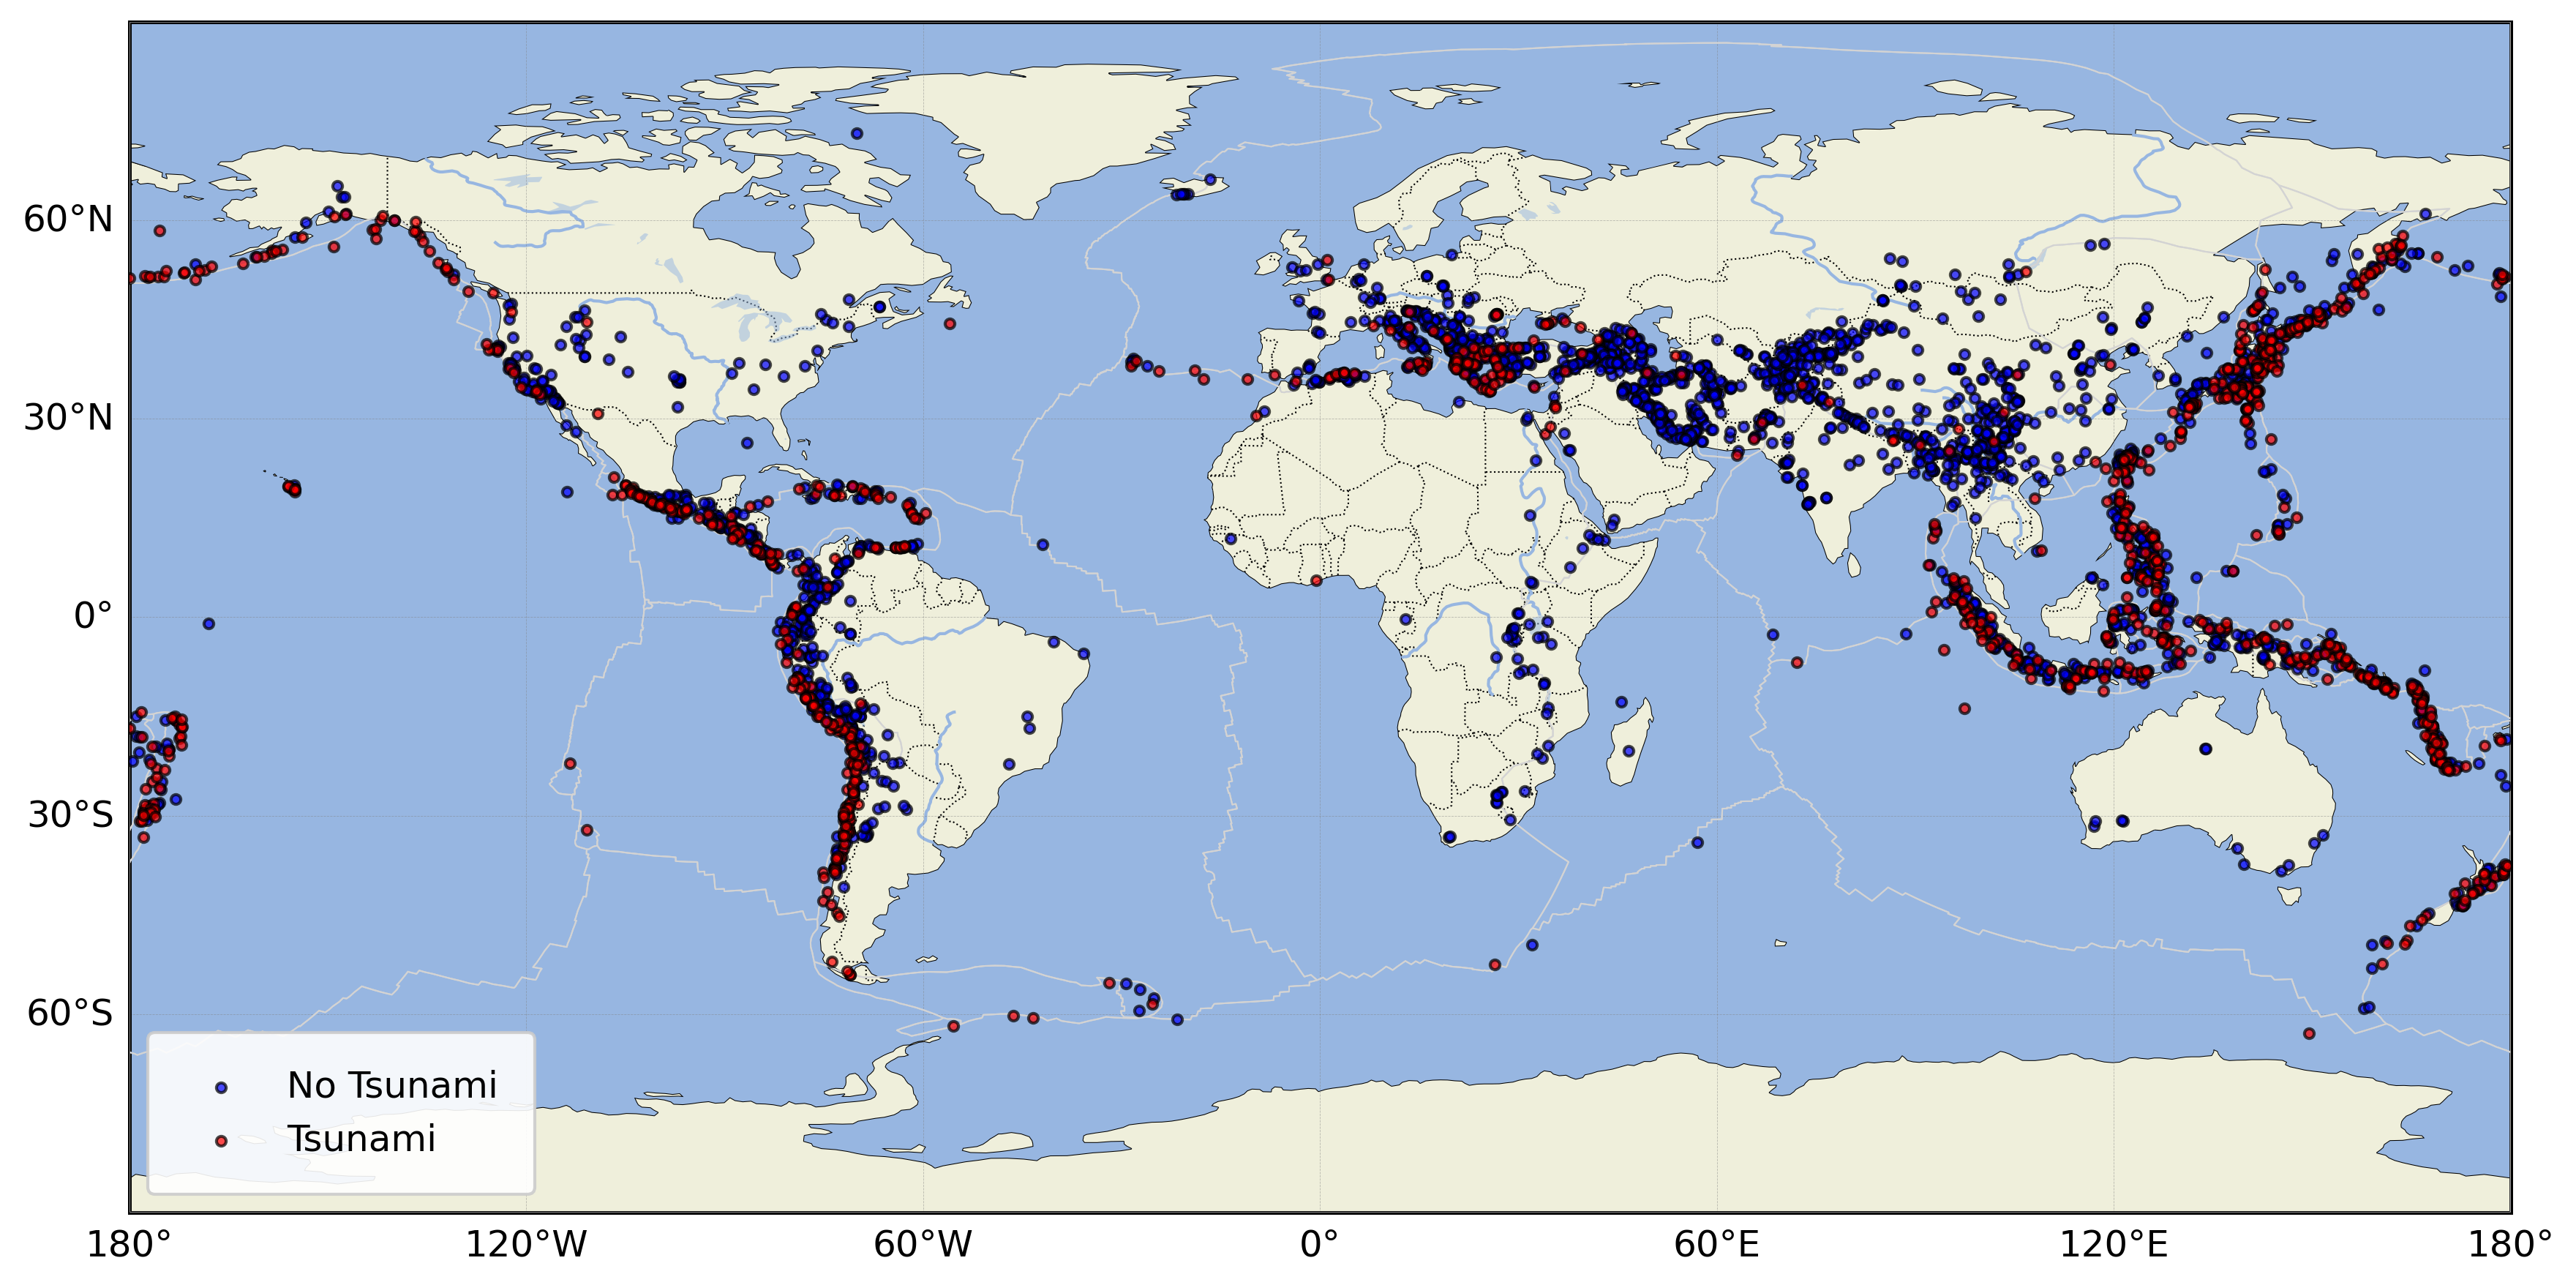

In [4]:
tectonic_plates = gpd.read_file('tectonicplates-master/PB2002_plates.shp')

fig = plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, zorder=2) 
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=2)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, zorder=2)
ax.add_feature(cfeature.OCEAN, zorder=2)
ax.add_feature(cfeature.LAKES, alpha=0.5, zorder=2)
ax.add_feature(cfeature.RIVERS, zorder=2)

gl = ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

tectonic_plates.plot(ax=ax, edgecolor='lightgray', facecolor='none', linewidth=0.5, transform=ccrs.PlateCarree(), zorder=3)

aux_rect = mpatches.Rectangle(
    xy=(0, 0),  
    width=1, height=1, 
    transform=ax.transAxes, 
    linewidth=0.1, edgecolor='black', facecolor='none', zorder=5
)
ax.add_patch(aux_rect)

tsunami = earthquakes[earthquakes['Tsu'] == 1]
no_tsunami = earthquakes[earthquakes['Tsu'] == 0]

ax.scatter(no_tsunami['Longitude'], no_tsunami['Latitude'], color='blue', label='No Tsunami', s=10, alpha=0.7, edgecolor='k', zorder=4)
ax.scatter(tsunami['Longitude'], tsunami['Latitude'], color='red', label='Tsunami', s=10, alpha=0.7, edgecolor='k', zorder=4)

plt.legend(loc='lower left', fontsize=12, frameon=True, framealpha=0.9, borderpad=1)

plt.show()

In [5]:
u = np.percentile(earthquakes['Mag'], 0.95)
earthquakes = earthquakes[earthquakes['Mag'] > u]

In [6]:
y_train_app = np.array(earthquakes['Tsu'])
x_train_app = np.array(earthquakes[['Longitude','Latitude', 'Focal Depth (km)']])

x_train_app[:, 0] = (x_train_app[:, 0] + 180) / 360
x_train_app[:, 1] = (x_train_app[:, 1] + 90) / 180

In [10]:
x_train_tensor = torch.tensor(x_train_app, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_app, dtype=torch.long)

model = KAN(width=[3, 2], grid=2, k=3)

dataset = {
    'train_input': x_train_tensor,
    'train_label': y_train_tensor,
    'test_input': x_train_tensor,
    'test_label': y_train_tensor
}

model.fit(dataset, opt="LBFGS", steps=100, loss_fn=torch.nn.CrossEntropyLoss());

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.04e-01 | test_loss: 7.04e-01 | reg: 9.45e+00 | : 100%|█| 100/100 [00:00<00:00, 122.2

saving model version 0.1


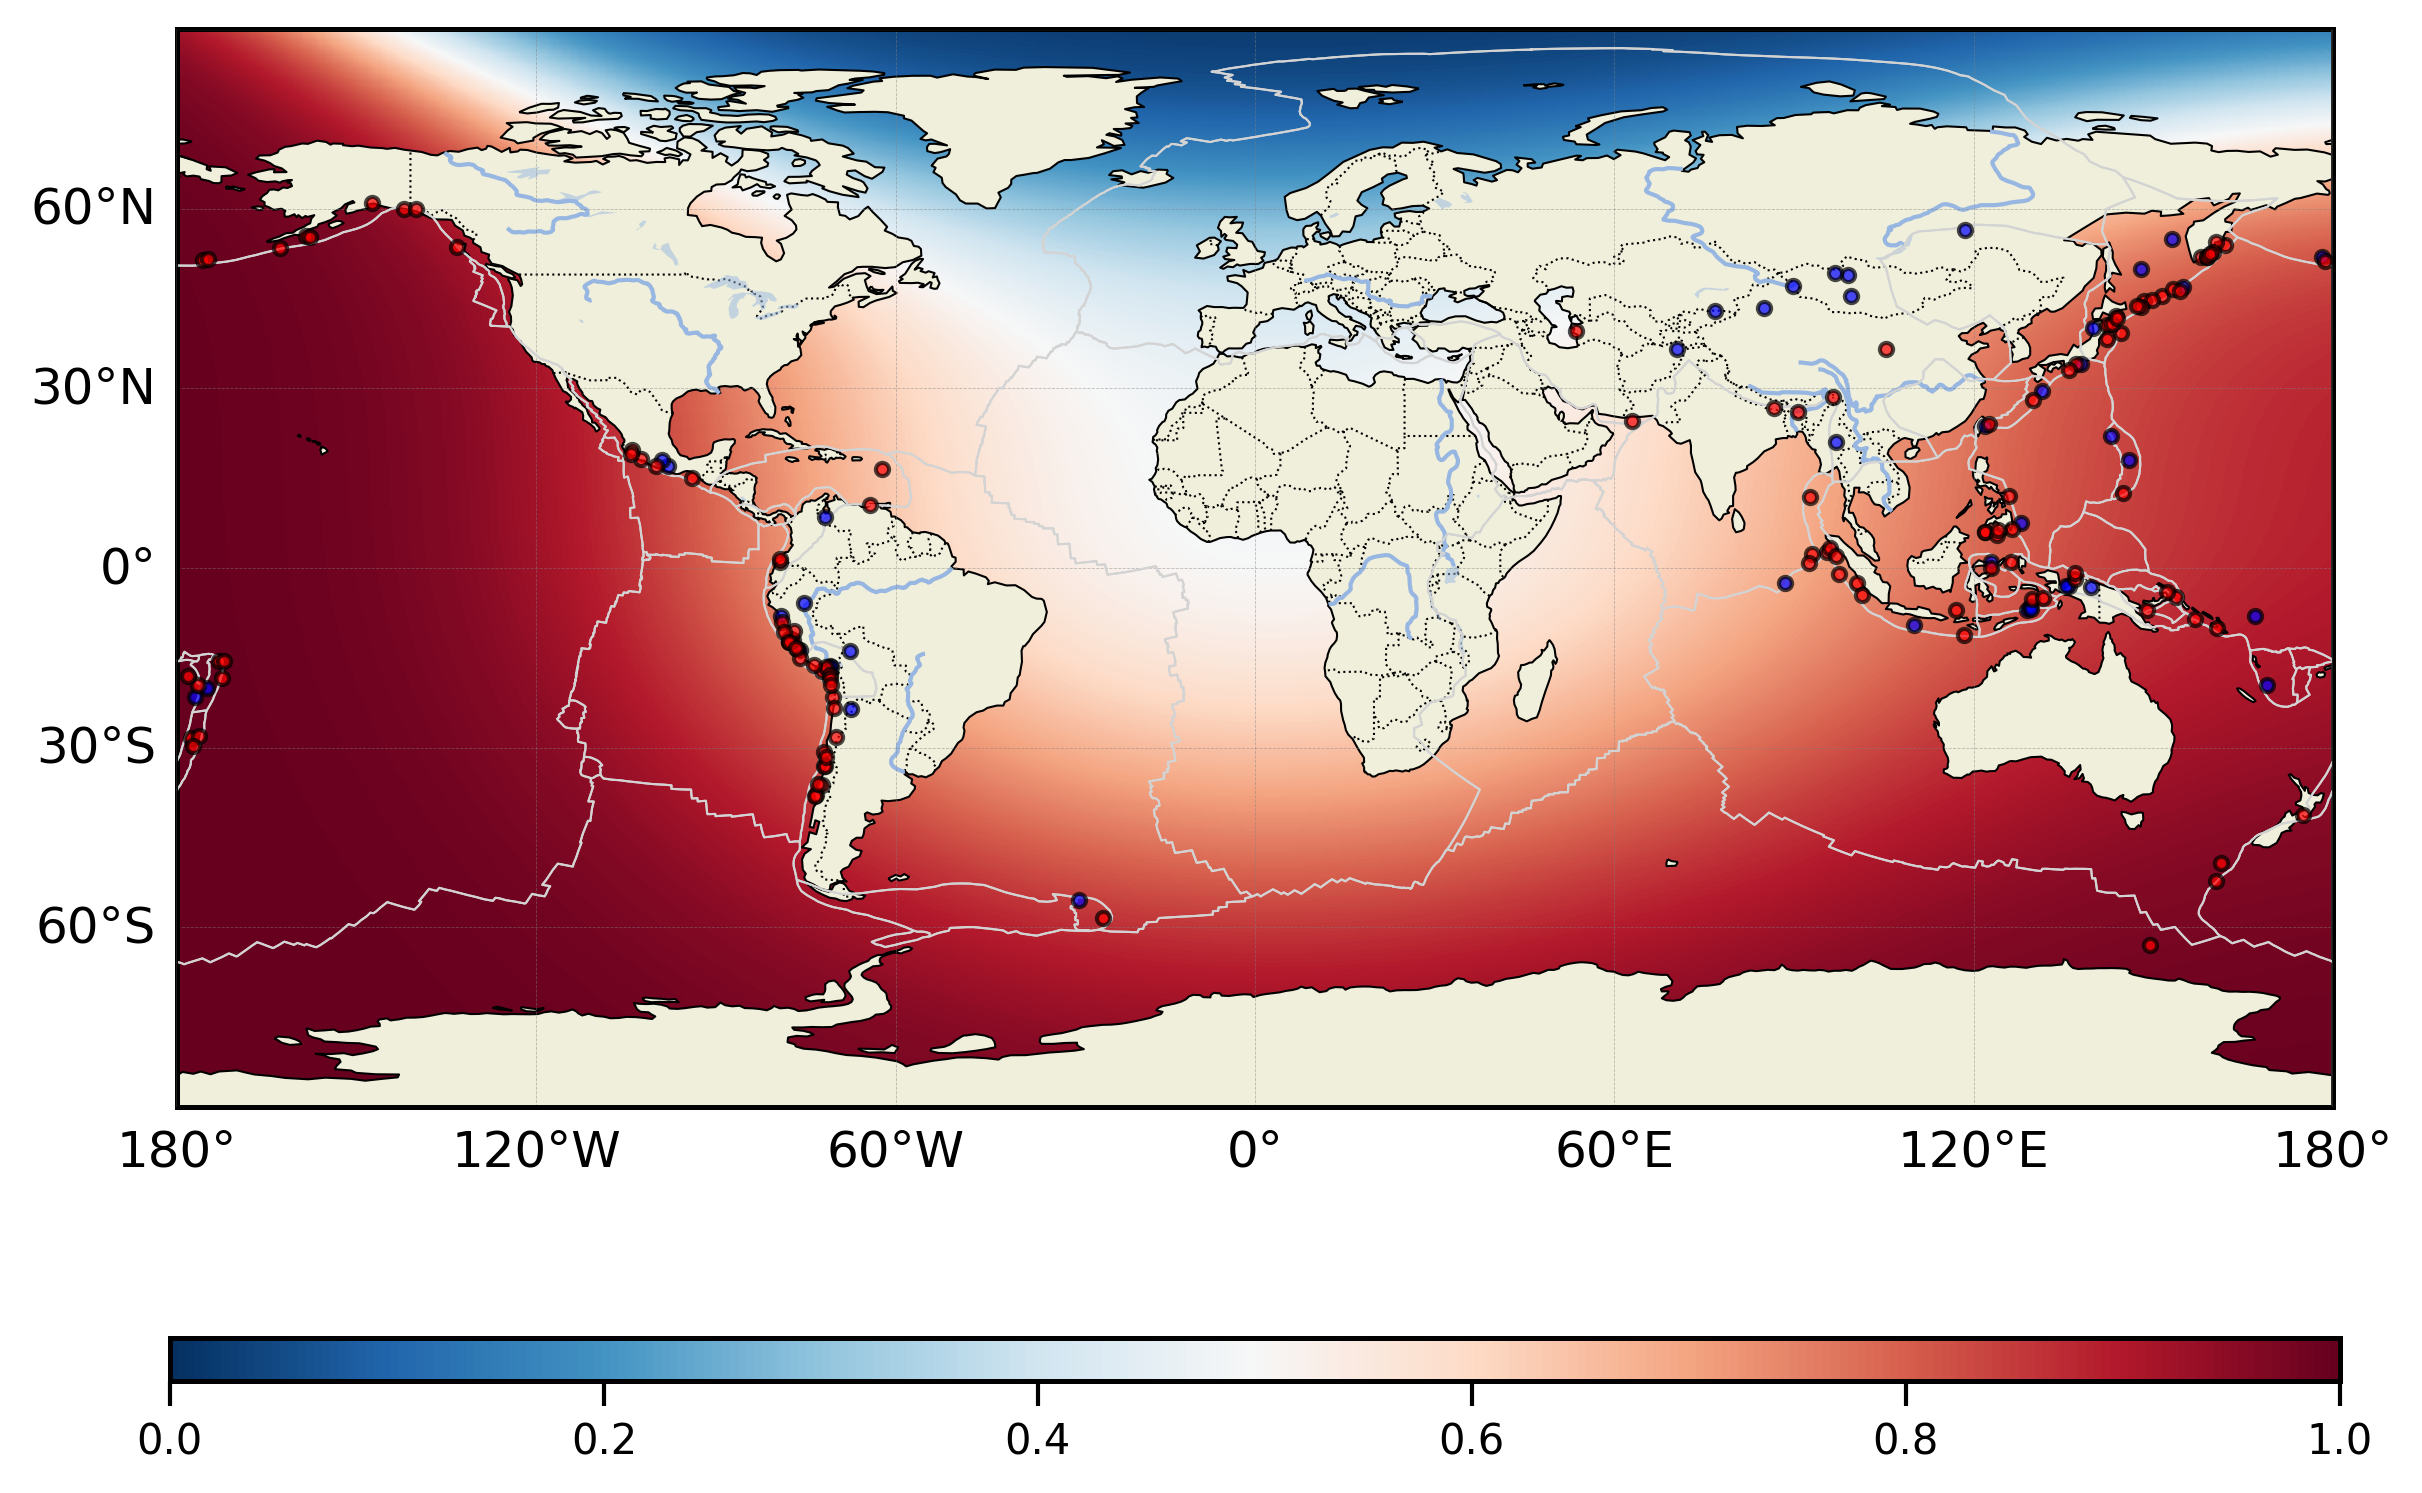

In [18]:
x_min, x_max = 0, 1
y_min, y_max = 0, 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                     np.linspace(y_min, y_max, 1000))
focal_depth_percentile = np.percentile(x_train_app[:, 2], 20)
fixed_depth = np.full(xx.ravel().shape, focal_depth_percentile)

grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel(), fixed_depth], dtype=torch.float32)

with torch.no_grad():
    Z = model(grid_tensor)
    Z = torch.softmax(Z, dim=1)
    probabilities = Z[:, 1].reshape(xx.shape)

latitudes = 180 * yy - 90
longitudes = 360 * xx - 180

fig = plt.figure(figsize=(14*2/3, 10*2/3))
ax = plt.axes(projection=ccrs.PlateCarree())

im = ax.pcolormesh(longitudes, latitudes, probabilities, shading='auto', cmap='RdBu_r', vmin=0, vmax=1, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, zorder=2)  
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=2)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, zorder=2)
ax.add_feature(cfeature.LAKES, alpha=0.5, zorder=2)
ax.add_feature(cfeature.RIVERS, zorder=2)

gl = ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

tectonic_plates.plot(ax=ax, edgecolor='lightgray', facecolor='none', linewidth=0.5, transform=ccrs.PlateCarree(), zorder=3)

aux_rect = mpatches.Rectangle(
    xy=(0, 0), 
    width=1, height=1,  
    transform=ax.transAxes, 
    linewidth=0.5, edgecolor='black', facecolor='none', zorder=5 
)
ax.add_patch(aux_rect)

tsunami = earthquakes[earthquakes['Tsu'] == 1]
no_tsunami = earthquakes[earthquakes['Tsu'] == 0]

ax.scatter(no_tsunami['Longitude'], no_tsunami['Latitude'], color='blue', label='No Tsunami', s=10, alpha=0.7, edgecolor='k', zorder=4)
ax.scatter(tsunami['Longitude'], tsunami['Latitude'], color='red', label='Tsunami', s=10, alpha=0.7, edgecolor='k', zorder=4)

cbar = fig.colorbar(im, ax=ax, orientation='horizontal')
cbar.ax.set_box_aspect(0.02)

plt.show()

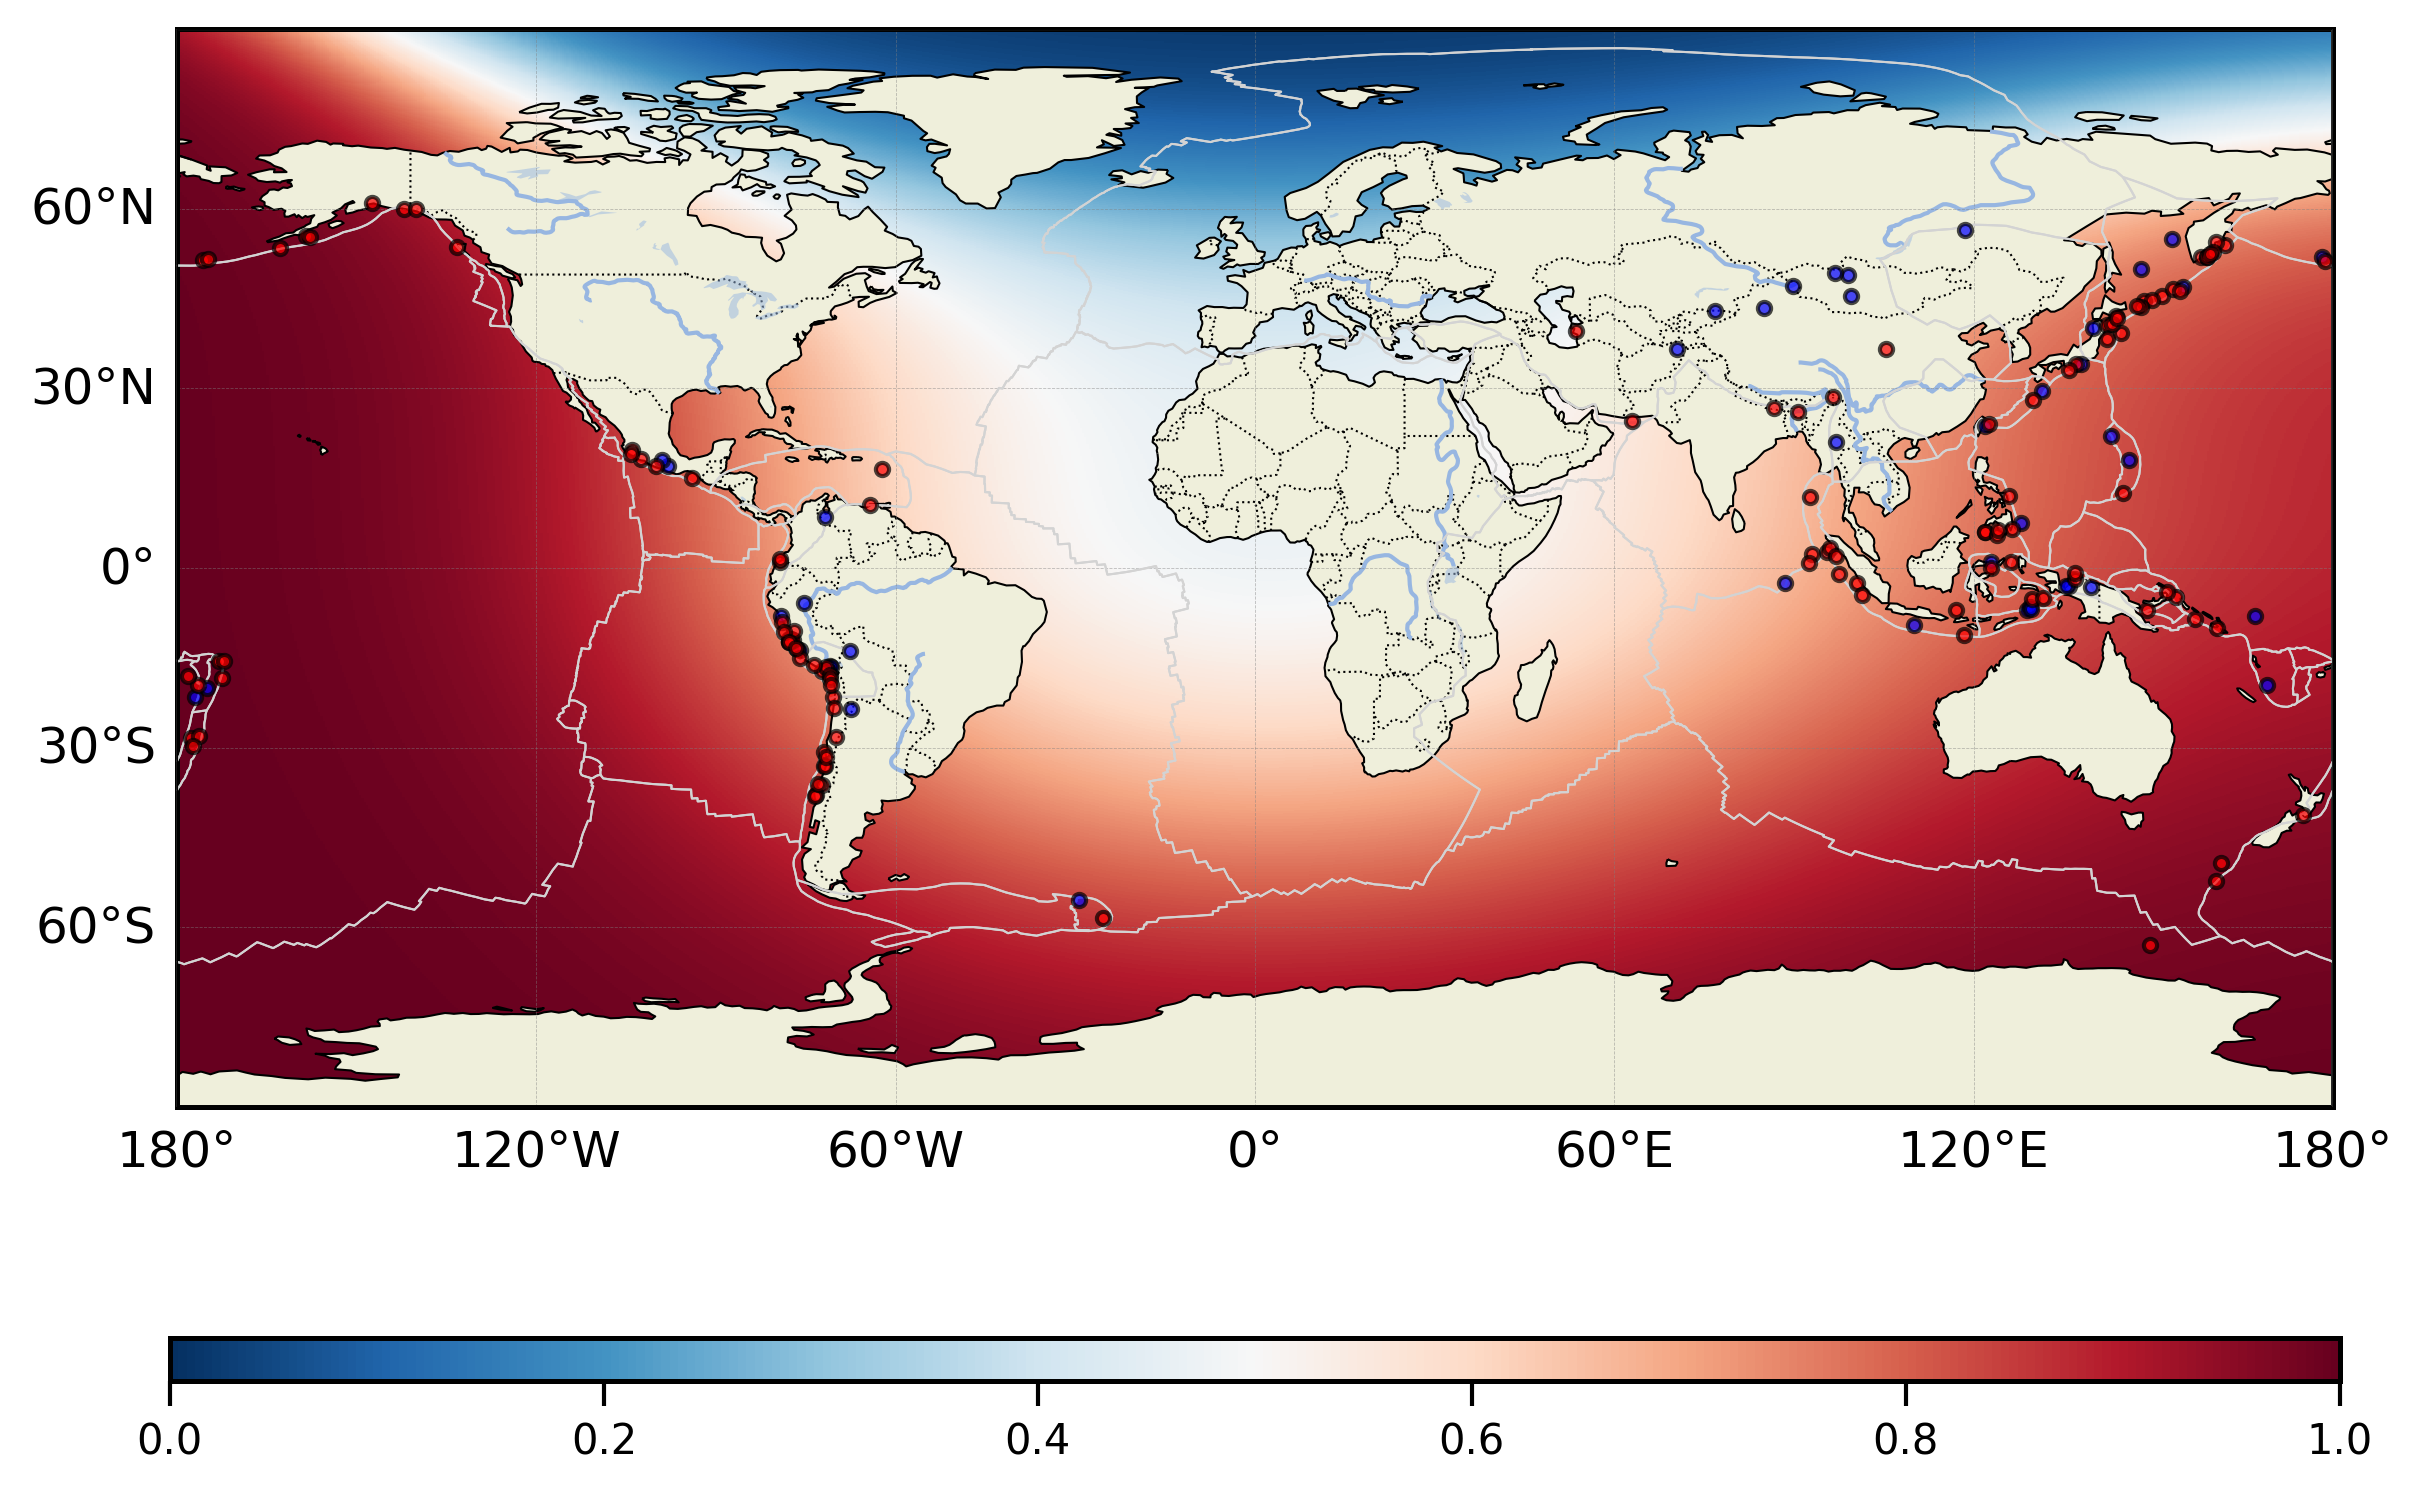

In [19]:
x_min, x_max = 0, 1
y_min, y_max = 0, 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                     np.linspace(y_min, y_max, 1000))
focal_depth_percentile = np.percentile(x_train_app[:, 2], 40)
fixed_depth = np.full(xx.ravel().shape, focal_depth_percentile)

grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel(), fixed_depth], dtype=torch.float32)

with torch.no_grad():
    Z = model(grid_tensor)
    Z = torch.softmax(Z, dim=1)
    probabilities = Z[:, 1].reshape(xx.shape)

latitudes = 180 * yy - 90
longitudes = 360 * xx - 180

fig = plt.figure(figsize=(14*2/3, 10*2/3))
ax = plt.axes(projection=ccrs.PlateCarree())

im = ax.pcolormesh(longitudes, latitudes, probabilities, shading='auto', cmap='RdBu_r', vmin=0, vmax=1, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, zorder=2)  
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=2)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, zorder=2)
ax.add_feature(cfeature.LAKES, alpha=0.5, zorder=2)
ax.add_feature(cfeature.RIVERS, zorder=2)

gl = ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

tectonic_plates.plot(ax=ax, edgecolor='lightgray', facecolor='none', linewidth=0.5, transform=ccrs.PlateCarree(), zorder=3)

aux_rect = mpatches.Rectangle(
    xy=(0, 0), 
    width=1, height=1,  
    transform=ax.transAxes, 
    linewidth=0.5, edgecolor='black', facecolor='none', zorder=5 
)
ax.add_patch(aux_rect)

tsunami = earthquakes[earthquakes['Tsu'] == 1]
no_tsunami = earthquakes[earthquakes['Tsu'] == 0]

ax.scatter(no_tsunami['Longitude'], no_tsunami['Latitude'], color='blue', label='No Tsunami', s=10, alpha=0.7, edgecolor='k', zorder=4)
ax.scatter(tsunami['Longitude'], tsunami['Latitude'], color='red', label='Tsunami', s=10, alpha=0.7, edgecolor='k', zorder=4)

cbar = fig.colorbar(im, ax=ax, orientation='horizontal')
cbar.ax.set_box_aspect(0.02)

plt.show()

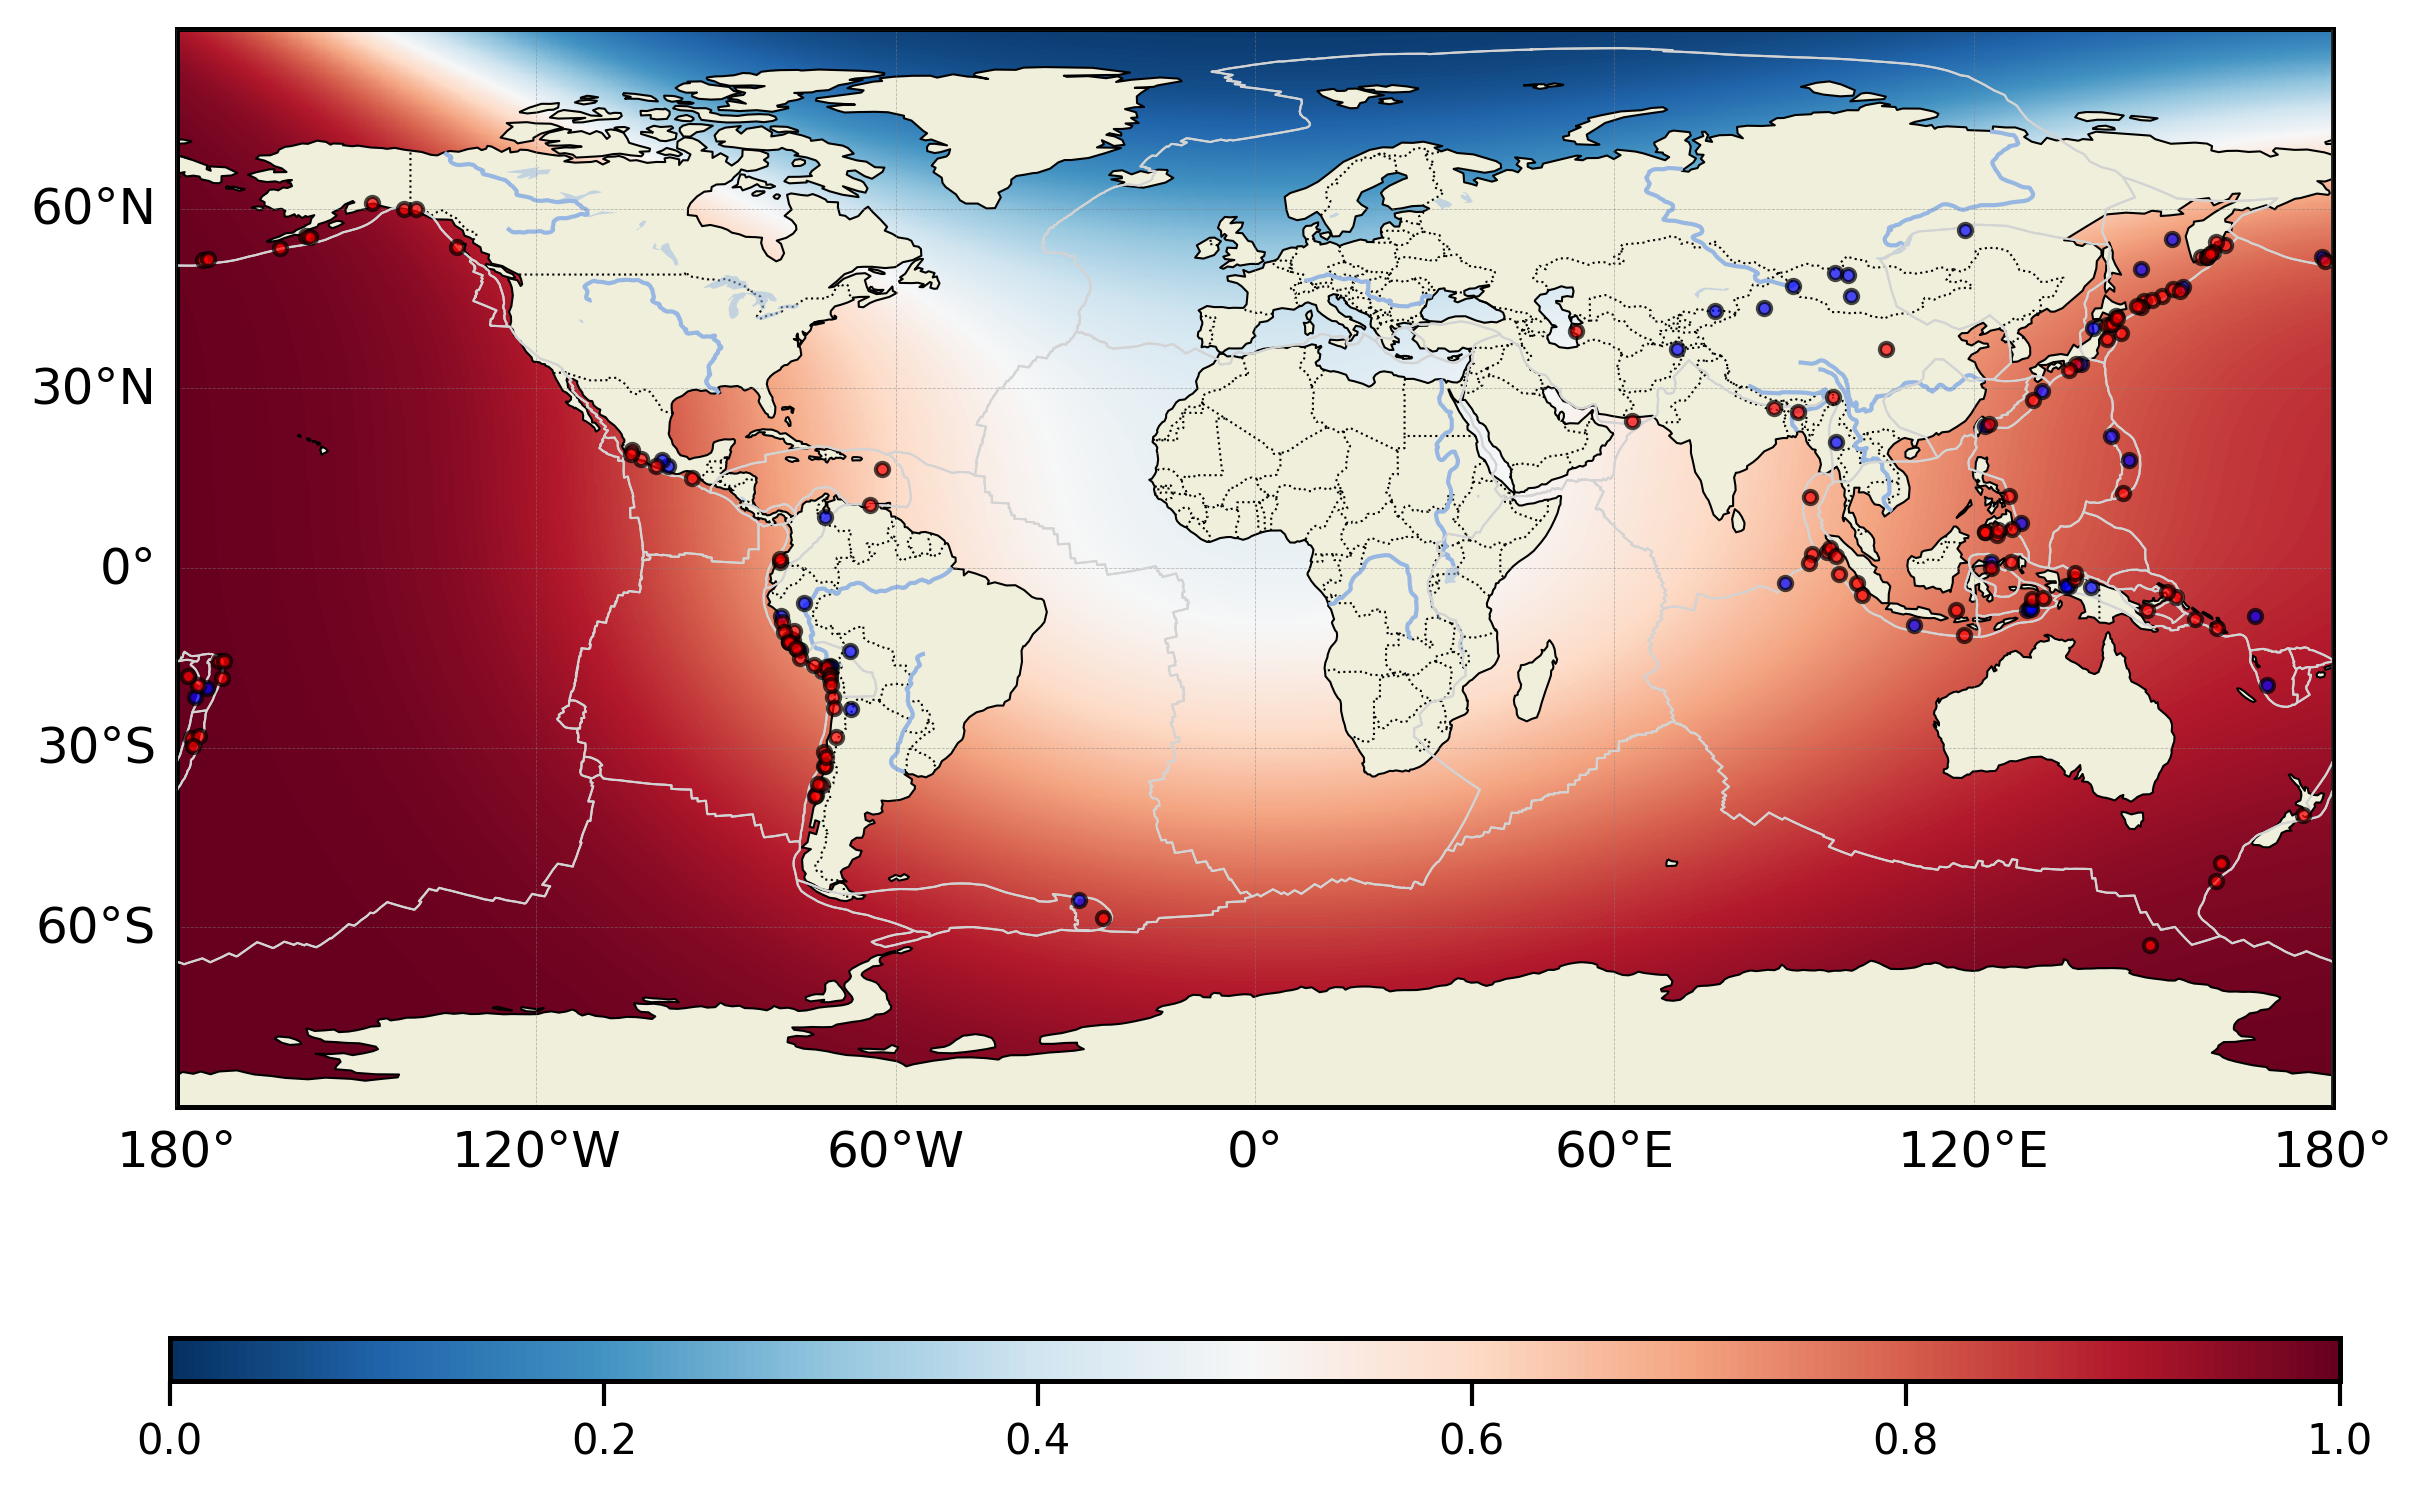

In [20]:
x_min, x_max = 0, 1
y_min, y_max = 0, 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                     np.linspace(y_min, y_max, 1000))
focal_depth_percentile = np.percentile(x_train_app[:, 2], 60)
fixed_depth = np.full(xx.ravel().shape, focal_depth_percentile)

grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel(), fixed_depth], dtype=torch.float32)

with torch.no_grad():
    Z = model(grid_tensor)
    Z = torch.softmax(Z, dim=1)
    probabilities = Z[:, 1].reshape(xx.shape)

latitudes = 180 * yy - 90
longitudes = 360 * xx - 180

fig = plt.figure(figsize=(14*2/3, 10*2/3))
ax = plt.axes(projection=ccrs.PlateCarree())

im = ax.pcolormesh(longitudes, latitudes, probabilities, shading='auto', cmap='RdBu_r', vmin=0, vmax=1, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, zorder=2)  
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=2)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, zorder=2)
ax.add_feature(cfeature.LAKES, alpha=0.5, zorder=2)
ax.add_feature(cfeature.RIVERS, zorder=2)

gl = ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

tectonic_plates.plot(ax=ax, edgecolor='lightgray', facecolor='none', linewidth=0.5, transform=ccrs.PlateCarree(), zorder=3)

aux_rect = mpatches.Rectangle(
    xy=(0, 0), 
    width=1, height=1,  
    transform=ax.transAxes, 
    linewidth=0.5, edgecolor='black', facecolor='none', zorder=5 
)
ax.add_patch(aux_rect)

tsunami = earthquakes[earthquakes['Tsu'] == 1]
no_tsunami = earthquakes[earthquakes['Tsu'] == 0]

ax.scatter(no_tsunami['Longitude'], no_tsunami['Latitude'], color='blue', label='No Tsunami', s=10, alpha=0.7, edgecolor='k', zorder=4)
ax.scatter(tsunami['Longitude'], tsunami['Latitude'], color='red', label='Tsunami', s=10, alpha=0.7, edgecolor='k', zorder=4)

cbar = fig.colorbar(im, ax=ax, orientation='horizontal')
cbar.ax.set_box_aspect(0.02)

plt.show()

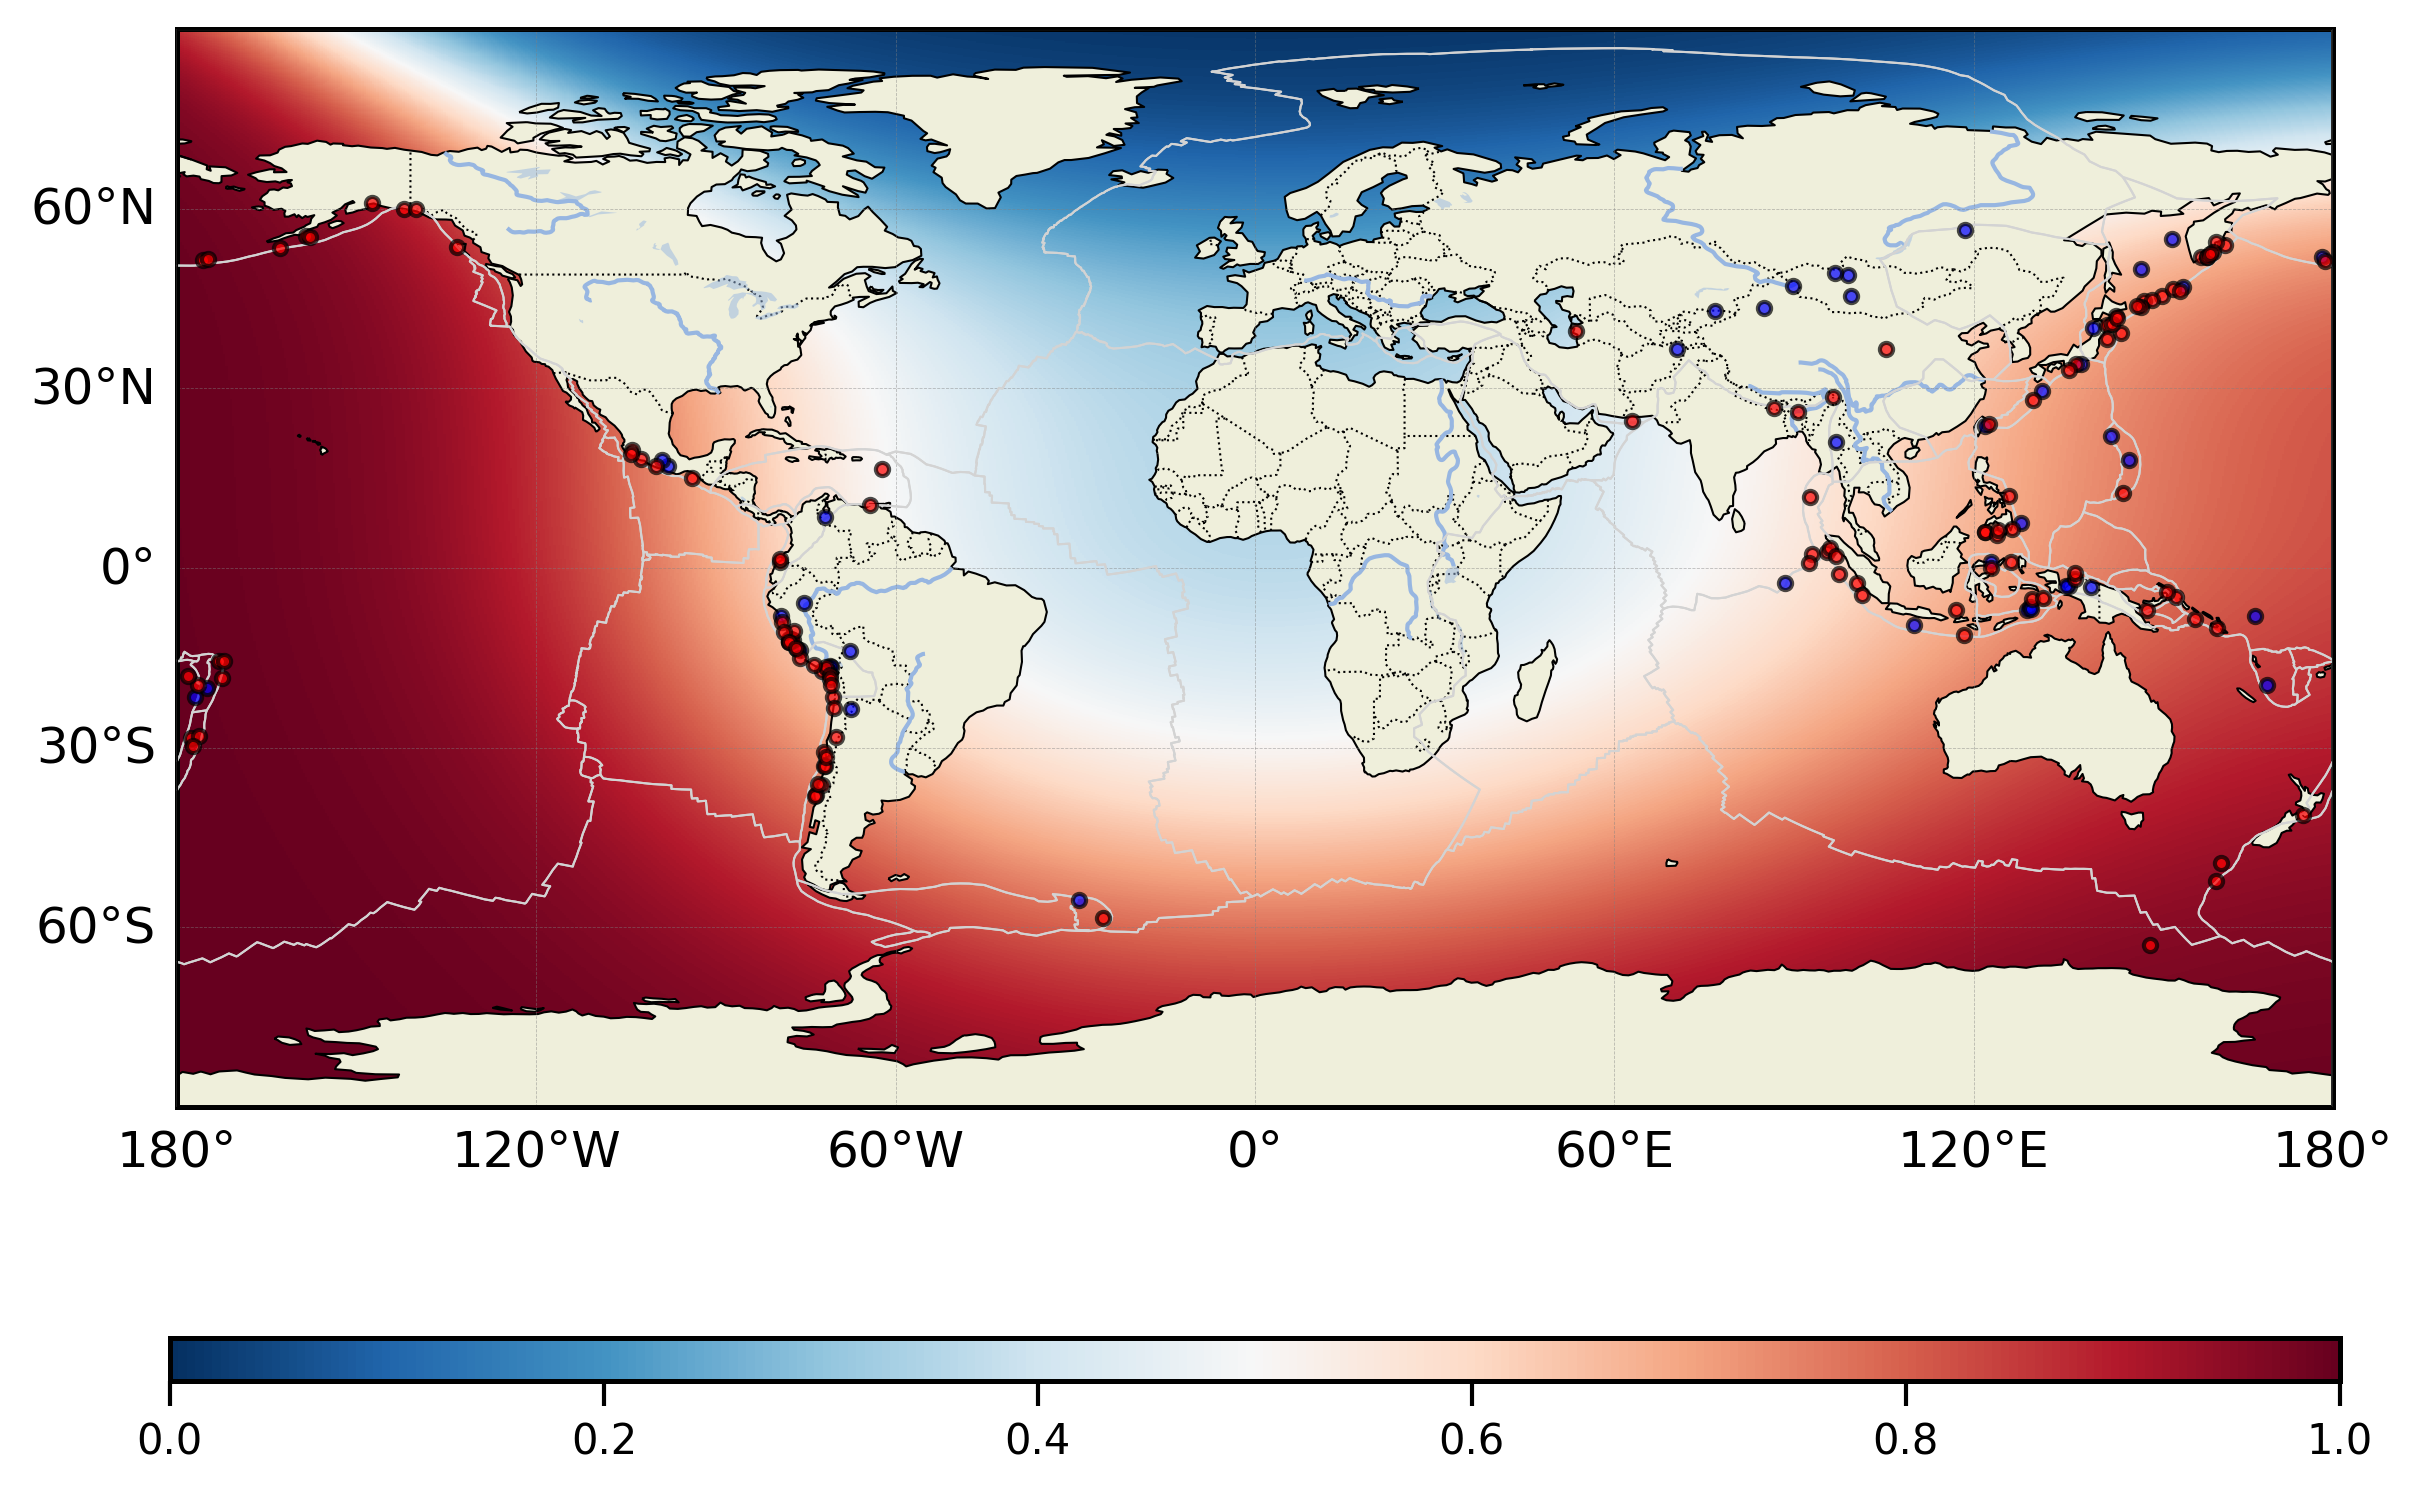

In [24]:
x_min, x_max = 0, 1
y_min, y_max = 0, 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                     np.linspace(y_min, y_max, 1000))
focal_depth_percentile = np.percentile(x_train_app[:, 2], 80)
fixed_depth = np.full(xx.ravel().shape, focal_depth_percentile)

grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel(), fixed_depth], dtype=torch.float32)

with torch.no_grad():
    Z = model(grid_tensor)
    Z = torch.softmax(Z, dim=1)
    probabilities = Z[:, 1].reshape(xx.shape)

latitudes = 180 * yy - 90
longitudes = 360 * xx - 180

fig = plt.figure(figsize=(14*2/3, 10*2/3))
ax = plt.axes(projection=ccrs.PlateCarree())

im = ax.pcolormesh(longitudes, latitudes, probabilities, shading='auto', cmap='RdBu_r', vmin=0, vmax=1, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, zorder=2)  
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=2)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, zorder=2)
ax.add_feature(cfeature.LAKES, alpha=0.5, zorder=2)
ax.add_feature(cfeature.RIVERS, zorder=2)

gl = ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

tectonic_plates.plot(ax=ax, edgecolor='lightgray', facecolor='none', linewidth=0.5, transform=ccrs.PlateCarree(), zorder=3)

aux_rect = mpatches.Rectangle(
    xy=(0, 0), 
    width=1, height=1,  
    transform=ax.transAxes, 
    linewidth=0.5, edgecolor='black', facecolor='none', zorder=5 
)
ax.add_patch(aux_rect)

tsunami = earthquakes[earthquakes['Tsu'] == 1]
no_tsunami = earthquakes[earthquakes['Tsu'] == 0]

ax.scatter(no_tsunami['Longitude'], no_tsunami['Latitude'], color='blue', label='No Tsunami', s=10, alpha=0.7, edgecolor='k', zorder=4)
ax.scatter(tsunami['Longitude'], tsunami['Latitude'], color='red', label='Tsunami', s=10, alpha=0.7, edgecolor='k', zorder=4)

cbar = fig.colorbar(im, ax=ax, orientation='horizontal')
cbar.ax.set_box_aspect(0.02)

plt.show()

## Data preparation for Dunn-Smyth Residualds

In [25]:
fixed_depth = np.percentile(earthquakes['Focal Depth (km)'].values, 20)
earthquake_data = np.column_stack((x_train_app[:, 0], x_train_app[:, 1], np.full(earthquakes['Latitude'].values.shape[0], fixed_depth)))
earthquake_tensor = torch.tensor(earthquake_data, dtype=torch.float32)

with torch.no_grad():
    Z_earthquake = model(earthquake_tensor)
    Z_earthquake = torch.softmax(Z_earthquake, dim=1)
    probabilities_earthquake = Z_earthquake[:, 1]

df = pd.DataFrame({
    'y_train': y_train_tensor.numpy(),
    'probabilities': probabilities_earthquake.numpy()
})

df.to_csv('Percentile 20.csv', index=False) 

In [26]:
fixed_depth = np.percentile(earthquakes['Focal Depth (km)'].values, 40)
earthquake_data = np.column_stack((x_train_app[:, 0], x_train_app[:, 1], np.full(earthquakes['Latitude'].values.shape[0], fixed_depth)))
earthquake_tensor = torch.tensor(earthquake_data, dtype=torch.float32)

with torch.no_grad():
    Z_earthquake = model(earthquake_tensor)
    Z_earthquake = torch.softmax(Z_earthquake, dim=1)
    probabilities_earthquake = Z_earthquake[:, 1]

df = pd.DataFrame({
    'y_train': y_train_tensor.numpy(),
    'probabilities': probabilities_earthquake.numpy()
})

df.to_csv('Percentile 40.csv', index=False) 

In [27]:
fixed_depth = np.percentile(earthquakes['Focal Depth (km)'].values, 60)
earthquake_data = np.column_stack((x_train_app[:, 0], x_train_app[:, 1], np.full(earthquakes['Latitude'].values.shape[0], fixed_depth)))
earthquake_tensor = torch.tensor(earthquake_data, dtype=torch.float32)

with torch.no_grad():
    Z_earthquake = model(earthquake_tensor)
    Z_earthquake = torch.softmax(Z_earthquake, dim=1)
    probabilities_earthquake = Z_earthquake[:, 1]

df = pd.DataFrame({
    'y_train': y_train_tensor.numpy(),
    'probabilities': probabilities_earthquake.numpy()
})

df.to_csv('Percentile 60.csv', index=False) 

In [28]:
fixed_depth = np.percentile(earthquakes['Focal Depth (km)'].values, 80)
earthquake_data = np.column_stack((x_train_app[:, 0], x_train_app[:, 1], np.full(earthquakes['Latitude'].values.shape[0], fixed_depth)))
earthquake_tensor = torch.tensor(earthquake_data, dtype=torch.float32)

with torch.no_grad():
    Z_earthquake = model(earthquake_tensor)
    Z_earthquake = torch.softmax(Z_earthquake, dim=1)
    probabilities_earthquake = Z_earthquake[:, 1]

df = pd.DataFrame({
    'y_train': y_train_tensor.numpy(),
    'probabilities': probabilities_earthquake.numpy()
})

df.to_csv('Percentile 80.csv', index=False) 